<a href="https://colab.research.google.com/github/streetlamplee/2023_electonic_usage_prediction/blob/main/2023_electronic_usage_prediction_AI_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전력사용량 예측 AI 경진대회


- 건물별 시간당 전력사용량을 예측하는 대회입니다.


- 건물별 전력사용량의 패턴을 파악하는게 핵심인 대회입니다.


- train data와 test data의 시간대가 다른, 시계열 문제입니다. 시계열 문제를 단순 회귀문제로 변환하여 푸는 방법을 알아봅니다.


- metric은 MAE를 사용합니다.


[Source] https://dacon.io/competitions/official/236125/overview/description

## 1. 라이브러리, 데이터 불러오기

In [1]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from lightgbm.sklearn import LGBMRegressor # sklearn API

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [4]:
# flag setting
feature_reducing = False # 'pca' or 'fi'

In [5]:
# 데이터를 불러옵니다.
base_path = '/content/drive/MyDrive/Colab Notebooks/electric_usage/'
train = pd.read_csv(base_path + 'train.csv')
building_info = pd.read_csv(base_path + 'building_info.csv')
test = pd.read_csv(base_path + 'test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

### column 설명

- num_date_time : (건물번호)_시간 (PK)
- 건물번호 : 1 ~ 100
- 일시 : 시간
- 기온, 강수량, 풍속, 습도, 일조, 일사 : 기상정보
- 전력소비량(target) : 건물별 시간당 전력소비량

In [6]:
train.info()
# memory usage: 15.6+ MB >> object를 처리하는 최소 치를 보여줌
train.info(memory_usage='deep')
# memory usage를 정확하게 알기 위한 parameter

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int

In [7]:
test.info()
# test data엔 결측치가 없음 + 일조, 일사 column이 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [8]:
building_info.head(5)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [9]:
## On your Own
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation',
                 'windspeed', 'humidity']

In [10]:
#### TO-DO ####
# building_info에 있는 '-'를 모두 0으로 바꾸고, dtype을 float로 변경하세요.
#1. replace
# building_info.replace('-',0)

#2. loc
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    building_info.loc[building_info[col] == '-', col] = 0.0

for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    building_info[col] = building_info[col].astype(float)

building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


<Axes: xlabel='date_time', ylabel='target'>

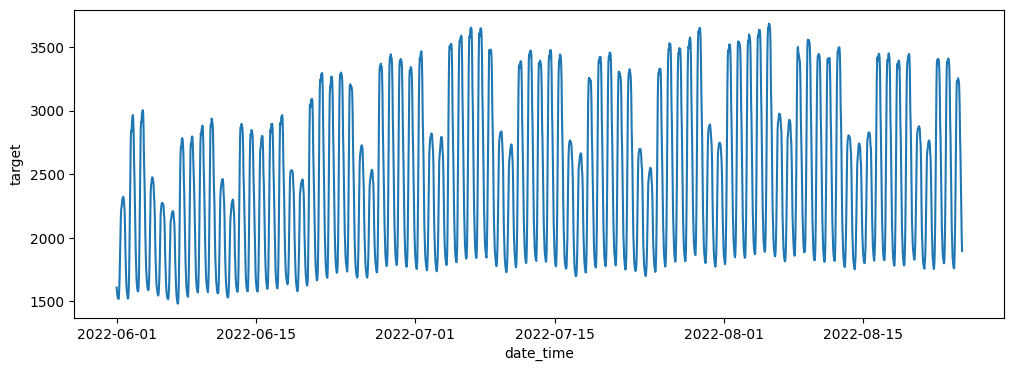

In [11]:
# 전력사용량 패턴
plt.figure(figsize = (12,4))
# sns.histplot(data=train, x='target')
train['date_time'] = pd.to_datetime(train['date_time'])
sns.lineplot(data = train, x = 'date_time', y = 'target',errorbar = None)

In [12]:
building_info.columns = ['num','type','area','cooling_area','solar','ESS','PCS']

In [13]:
# SQL JOIN
train = pd.merge(train, building_info, on = 'num', how = 'left')

In [14]:
#한글 글꼴 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [15]:
import matplotlib as mpl
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# 건물 유형별로 전력사용량 패턴 보기
# train.type.value_counts()
# for btype in train.type.unique():
#     plt.figure(figsize = (12,2))
#     plt.title(btype)
#     b = train[train.type == btype]
#     sns.lineplot(data = b, x = 'data_time', y = 'target', errorbar = None)
#     plt.show()


# 건물별로 전력사용량 패턴 보기
# for bn in train.num.unique():
#     plt.figure(figsize = (12,2))
#     plt.title(f'Building {bn}')
#     b = train[train.num == bn]
#     sns.lineplot(data = b, x = 'date_time', y = 'target', errorbar = None)
#     plt.show()

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

1) 모든 건물정보를 다 하나의 데이터에 넣고 하나의 모델로 예측

-건물 정보를 feature로 넣겠다는 뜻.

2) 건물 타입별로 데이터를 나누고, 각각의 모델로 예측

- 건물타입은 주어진 타입을 사용할 수 있고, 직접 grouping해서 쓸 수도 있음.

3) 건물별로 데이터를 나누고, 각각의 모델로 예측 (모델이 100개)

#### 결측치 처리

In [16]:
# 결측치가 있는 기상정보들의 결측치 채우기
## 강수량 - 결측치를 0으로 채우자
## windspeed, humidity - interpolation (보간법)
train.info()
train['precipitation'] = train['precipitation'].fillna(0)
train['windspeed'] = train['windspeed'].interpolate(method = 'linear')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  43931 non-null   float64       
 5   windspeed      203981 non-null  float64       
 6   humidity       203991 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area           204000 non-null  float64       
 10  cooling_area   204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [17]:
# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
train = pd.get_dummies(data = train, columns = ['type'])

In [18]:
# time feature --> 월/일/시/요일
train['month'] = train.date_time.dt.month
train['day'] = train.date_time.dt.day
train['hour'] = train.date_time.dt.hour
train['dow'] = train.date_time.dt.day_of_week # 0 ~ 6 : 월 ~ 일
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      204000 non-null  float64       
 6   humidity       203991 non-null  float64       
 7   target         204000 non-null  float64       
 8   area           204000 non-null  float64       
 9   cooling_area   204000 non-null  float64       
 10  solar          204000 non-null  float64       
 11  ESS            204000 non-null  float64       
 12  PCS            204000 non-null  float64       
 13  type_건물기타      204000 non-null  uint8         
 14  type_공공        204000 non-null  uint8         
 15  

In [34]:
cluster_df

,0,1,2,3,4,5,6,7,8,9,...,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039
1,1085.28,1047.36,974.88,953.76,986.40,1087.20,1314.72,1684.80,1976.16,2289.12,...,4287.36,4084.32,3906.24,3063.84,2603.52,2517.12,2208.96,1806.24,1387.20,1925.28
2,1170.36,1146.96,1115.28,1107.00,1069.92,1075.32,1116.36,1254.24,887.40,1035.00,...,2076.48,2199.60,2160.72,2058.48,1951.92,1866.96,1693.80,1564.92,948.96,1348.92
3,926.28,884.52,882.36,867.24,880.92,808.56,786.24,809.64,818.64,882.36,...,1677.24,1777.68,1877.40,1871.28,2382.84,2729.16,2664.00,2135.16,1158.84,1025.28
4,740.16,671.04,619.20,626.40,626.22,630.36,752.04,829.44,957.60,1093.14,...,1324.80,1299.60,1245.24,1142.46,970.56,847.08,782.10,751.86,763.56,719.64
5,1304.64,1308.24,1302.48,1295.28,1316.88,1398.96,1492.56,1535.04,1548.72,1560.96,...,2743.92,3198.96,2880.72,2461.68,1997.28,1776.24,1675.44,1604.88,1568.16,1543.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1576.68,1558.68,1413.36,1483.92,1438.56,1503.84,1738.80,2073.36,2263.80,2621.04,...,3198.96,3330.36,3222.96,3213.00,3304.92,3164.16,2977.68,2875.44,2396.04,2284.08
97,774.36,553.86,558.90,559.44,559.62,582.48,640.26,903.78,855.18,907.56,...,1526.22,1522.26,1441.44,1413.90,1411.38,1250.64,1184.58,1151.28,1121.58,987.30
98,533.52,516.78,509.40,479.70,541.98,712.08,947.88,1004.58,1069.02,1133.64,...,1296.90,1194.84,1215.36,1214.46,1122.66,1107.00,1053.18,971.82,815.94,632.34
99,642.96,603.36,581.22,599.94,595.62,594.00,706.50,811.98,961.38,1164.24,...,1356.66,1389.42,1410.48,1418.76,1327.14,1299.24,1276.92,1062.00,865.62,752.58


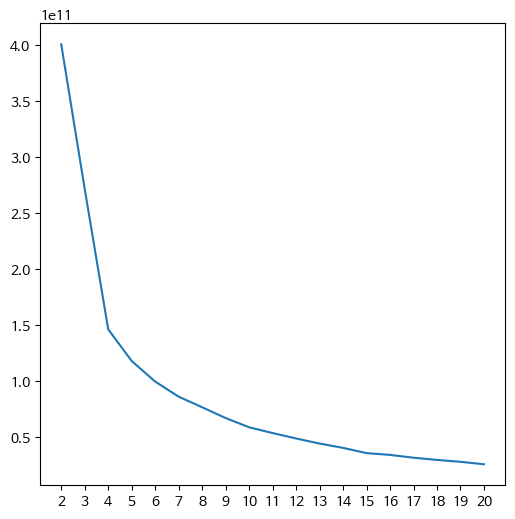

In [33]:
# 전력사용량 clustering
from sklearn.cluster import KMeans

cluster_df = pd.DataFrame()

for bn in range(1,101):
    cluster_df[bn] = train.loc[train.num == bn, 'target'].values

cluster_df = cluster_df.T

# elbow method
krange = range(2,21)
inertias = []
label_list = []

for K in krange:
    km = KMeans(n_clusters = K, n_init=30, random_state = 42)
    labels = km.fit_predict(cluster_df) #100 x 2040
    inertia = km.inertia_
    inertias.append(inertia)
    label_list.append(labels)

plt.figure(figsize=(6,6))
plt.plot(krange, inertias)
plt.xticks(krange)
plt.show()

In [36]:
# choose optimal K
optimal_k = 4
cluster_list = label_list[optimal_k-2]

In [37]:
# group별 데이터 분할
cluster_df = pd.DataFrame({'num': np.arange(1, 101),
                           'cluster' : cluster_list})
train = pd.merge(train, cluster_df, on = 'num')

In [22]:
train

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area,cooling_area,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,cluster
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,110634.00,39570.00,...,0,0,0,0,0,6,1,0,2,2
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,110634.00,39570.00,...,0,0,0,0,0,6,1,1,2,2
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,110634.00,39570.00,...,0,0,0,0,0,6,1,2,2,2
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,110634.00,39570.00,...,0,0,0,0,0,6,1,3,2,2
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,110634.00,39570.00,...,0,0,0,0,0,6,1,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,...,0,0,0,0,1,8,24,19,2,0
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,...,0,0,0,0,1,8,24,20,2,0
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,...,0,0,0,0,1,8,24,21,2,0
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,...,0,0,0,0,1,8,24,22,2,0


### 4. 학습 데이터 분할

In [23]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X1 = train[train.cluster == 0].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
y1 = train[train.cluster == 0].target
X2 = train[train.cluster == 1].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
y2 = train[train.cluster == 1].target
X3 = train[train.cluster == 2].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
y3 = train[train.cluster == 2].target
X4 = train[train.cluster == 3].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
y4 = train[train.cluster == 3].target

# K-fold CV를 하면 이 방법론 자체에서 validation을 충분히 수행하기 때문에, validation data를 train_test_split을 통해서 나눌 필요가 없음.
# OOF(Out-Of-Fold) prediction은 K-fold CV에서 사용하지 않은 작은 데이터로 최종 검증을 한번 해보는 방법.

# for OOF-prediction split 5% of data as validation dataset. 95%는 K-fold CV에 사용, 5%는 prediction에 사용
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.05, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.05, random_state=42)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=0.05, random_state=42)
X4_train, X4_val, y4_train, y4_val = train_test_split(X4, y4, test_size=0.05, random_state=42)

data = list()
data.append([X1_train, X1_val, y1_train, y1_val])
data.append([X2_train, X2_val, y2_train, y2_val])
data.append([X3_train, X3_val, y3_train, y3_val])
data.append([X4_train, X4_val, y4_train, y4_val])

### 5. 학습 및 평가

In [46]:
from sklearn.metrics import mean_absolute_error, r2_score
def lgbm(x,x_val,y, y_val):
    model = LGBMRegressor(random_state = 42)

    print("\nFitting LightGBM...")
    model.fit(x, y)

    evaluation_metric = r2_score
    evaluation_metric = mean_absolute_error

    print("Prediction")
    pred_train = model.predict(x)
    pred_val = model.predict(x_val)


    train_score = evaluation_metric(y, pred_train)
    val_score = evaluation_metric(y_val, pred_val)

    print("Train Score : %.4f" % train_score)
    print("Validation Score : %.4f" % val_score)


    print("Average target value : %.4f" % np.mean(y))
    mean_list = np.mean(y) * np.ones(len(y))
    print("Average absolute error : %.4f" % evaluation_metric(y, mean_list))
    return model

In [49]:
models = []
for idx, v in enumerate(data):
    print(f"{idx} 번째 cluster 학습결과")
    print("=======================================")
    models.append(lgbm(v[0], v[1], v[2], v[3]))
    print("=======================================\n")

0 번째 cluster 학습결과

Fitting LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 131784, number of used features: 26
[LightGBM] [Info] Start training from score 1510.451521
Prediction
Train Score : 148.6410
Validation Score : 146.0553
Average target value : 1510.4515
Average absolute error : 656.6740

1 번째 cluster 학습결과

Fitting LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 8
[LightGBM] [Info] Start training 

### 6. Hyper-parameter Tuning

In [26]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('numleaves',[1023, 2047, 4095])
    max_depth = trial.suggest_int('max_depth', 13, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 25)
    reg_lambda = trial.suggest_float('reg_lambda', 5.0, 20.0)
    colsample_bytree = trial.suggest_categorical('colsample_bytree',[0.5,0.7])
    evaluation_metric = mean_absolute_error

    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          reg_lambda=reg_lambda,
                          colsample_bytree=colsample_bytree,
                          random_state=42,
                          verbose = -1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [27]:
def fine_tuning_lgbm(x,x_val,y,y_val):
    K = 5   # Kfold 수
    evaluation_metric = mean_absolute_error
    # optimizer 함수에 parameter passing을 하고 싶은 경우
    opt_func = partial(optimizer, X=x, y=y, K=K)

    study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
    study.optimize(opt_func, n_trials=10)
    # optuna가 시도했던 모든 실험 관련 데이터
    study.trials_dataframe()
    print("Best Score: %.4f" % study.best_value) # best score 출력
    print("Best params: ", study.best_trial.params,'\n') # best score일 때의 하이퍼파라미터들

    optuna.visualization.plot_optimization_history(study)

    # hyper-parameter들의 중요도
    optuna.visualization.plot_param_importances(study)

    # Model Finalization
    best_params = study.best_params

    return best_params

In [39]:
params = []
for idx,v in enumerate(data):
    print(f"{idx}번째 cluster finetuning")
    print("======================================")
    params.append(fine_tuning_lgbm(v[0], v[1], v[2], v[3]))
    best_model = model = LGBMRegressor(**params[idx],
                                        random_state=42,
                                        verbose = -1)
    best_model.fit(v[0], v[2])
    print("validation MAE : %.4f" % mean_absolute_error(v[3], best_model.predict(v[1])))
    print("======================================")

[I 2023-11-29 09:11:14,895] A new study created in memory with name: no-name-17f53a33-91e9-4472-ac8f-23328b3177ea


0번째 cluster finetuning


[I 2023-11-29 09:12:29,739] Trial 0 finished with value: 96.03413719966083 and parameters: {'numleaves': 4095, 'max_depth': 16, 'learning_rate': 0.046349403085452365, 'n_estimators': 177, 'min_child_samples': 22, 'reg_lambda': 19.093412397661275, 'colsample_bytree': 0.5}. Best is trial 0 with value: 96.03413719966083.
[I 2023-11-29 09:14:04,303] Trial 1 finished with value: 93.54996013650678 and parameters: {'numleaves': 4095, 'max_depth': 17, 'learning_rate': 0.06106879628182363, 'n_estimators': 144, 'min_child_samples': 14, 'reg_lambda': 17.799827333940918, 'colsample_bytree': 0.5}. Best is trial 1 with value: 93.54996013650678.
[I 2023-11-29 09:15:26,692] Trial 2 finished with value: 71.93832366825703 and parameters: {'numleaves': 4095, 'max_depth': 14, 'learning_rate': 0.08093399570181088, 'n_estimators': 193, 'min_child_samples': 25, 'reg_lambda': 13.15228421962973, 'colsample_bytree': 0.7}. Best is trial 2 with value: 71.93832366825703.
[I 2023-11-29 09:16:18,242] Trial 3 finishe

KeyboardInterrupt: ignored

hyperparameter의 importance를 확인해서 1개의 파라미터가 유독 높다면, 그 파라미터의 값을 고정해서 추가로 실험할 수 있다.

2개 이상의 파라미터가 높게 나온다면, 그 중에서 한개를 고정해서 실험을 해본다. 동시에 하면 실험 대조군이 애매해지므로 되도록이면 하나씩 고정하는 것을 목표로 한다.

In [ ]:
# Model Finalization
best_params = study.best_params
best_model = model = LGBMRegressor(**best_params,
                                    random_state=42,
                                    verbose = -1)
best_model.fit(X_train, y_train)
print("validation MAE : %.4f" % evaluation_metric(y_val, best_model.predict(X_val)))

In [ ]:
# feature importance
fi_df = pd.DataFrame({'features':best_model.feature_name_,
                      'importances': best_model.feature_importances_})
fi_df.sort_values(by='importances', ascending = False)

### 7. 테스트 및 제출 파일 생성

In [ ]:
# Make KFold OOF prediction
def oof_preds(best_model):

    # make KFold
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    final_preds = []
    losses = []
    # fitting with best_model
    for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")




        loss = evaluation_metric(y_val, preds)

        losses.append(loss)

    avg_loss = np.mean(losses)
    print(f"Loss : {avg_loss:.4f}")
    return final_preds

In [32]:
test.head(3)

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75


In [56]:
## TO-DO ##
# X_test 만들기 : 앞서했던 전처리를 동일하게 적용해주면 됨.
X_test = test
X_test['date_time'] = pd.to_datetime(X_test['date_time'])
X_test = pd.merge(X_test, building_info, on = 'num', how = 'left')
X_test['precipitation'] = X_test['precipitation'].fillna(0)
X_test['windspeed'] = X_test['windspeed'].interpolate(method = 'linear')
X_test = pd.get_dummies(data = X_test, columns = ['type'])
X_test['month'] = X_test.date_time.dt.month
X_test['day'] = X_test.date_time.dt.day
X_test['hour'] = X_test.date_time.dt.hour
X_test['dow'] = X_test.date_time.dt.day_of_week # 0 ~ 6 : 월 ~ 일
X_test = pd.merge(X_test, cluster_df, on = 'num')
X_test.head(2)

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,area,cooling_area,solar,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,cluster
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,110634.0,39570.0,0.0,...,0,0,0,0,0,8,25,0,3,2
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,110634.0,39570.0,0.0,...,0,0,0,0,0,8,25,1,3,2


In [55]:
Xtest1

,num,temperature,precipitation,windspeed,humidity,target,area,cooling_area,solar,ESS,...,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,cluster_x,cluster_y
2040,2,18.6,0.0,0.9,42.0,1170.36,122233.47,99000.00,0.0,0.0,...,0,0,0,0,6,1,0,2,0,0
2041,2,18.0,0.0,1.1,45.0,1146.96,122233.47,99000.00,0.0,0.0,...,0,0,0,0,6,1,1,2,0,0
2042,2,17.7,0.0,1.5,45.0,1115.28,122233.47,99000.00,0.0,0.0,...,0,0,0,0,6,1,2,2,0,0
2043,2,16.7,0.0,1.4,48.0,1107.00,122233.47,99000.00,0.0,0.0,...,0,0,0,0,6,1,3,2,0,0
2044,2,18.4,0.0,2.8,43.0,1069.92,122233.47,99000.00,0.0,0.0,...,0,0,0,0,6,1,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.0,0.9,86.0,881.04,57497.84,40035.23,0.0,0.0,...,0,0,0,1,8,24,19,2,0,0
203996,100,22.4,0.0,1.3,86.0,798.96,57497.84,40035.23,0.0,0.0,...,0,0,0,1,8,24,20,2,0,0
203997,100,21.3,0.0,1.0,92.0,825.12,57497.84,40035.23,0.0,0.0,...,0,0,0,1,8,24,21,2,0,0
203998,100,21.0,0.0,0.3,94.0,640.08,57497.84,40035.23,0.0,0.0,...,0,0,0,1,8,24,22,2,0,0


In [57]:
Xtest1 = X_test[X_test.cluster == 0].drop(columns=['num_date_time', 'date_time', 'cluster'])
Xtest2 = X_test[X_test.cluster == 1].drop(columns=['num_date_time', 'date_time', 'cluster'])
Xtest3 = X_test[X_test.cluster == 2].drop(columns=['num_date_time', 'date_time', 'cluster'])
Xtest4 = X_test[X_test.cluster == 3].drop(columns=['num_date_time', 'date_time', 'cluster'])
for idx, v in enumerate([Xtest1, Xtest2, Xtest3, Xtest4]):
    pred = models[idx].predict(v)
    v['pred'] = pred

In [64]:
Xtest3

,num,temperature,precipitation,windspeed,humidity,area,cooling_area,solar,ESS,PCS,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,pred
0,1,23.5,0.0,2.2,72,110634.0,39570.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,0,3,1841.809834
1,1,23.0,0.0,0.9,72,110634.0,39570.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,1,3,1799.003145
2,1,22.7,0.0,1.5,75,110634.0,39570.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,2,3,1711.814313
3,1,22.1,0.0,1.3,78,110634.0,39570.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,3,3,1687.613410
4,1,21.8,0.0,1.0,77,110634.0,39570.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,4,3,1687.613410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16123,96,21.8,0.0,2.2,92,93314.0,60500.0,0.0,0.0,0.0,...,0,0,0,0,1,8,31,19,2,3158.084591
16124,96,21.5,0.0,2.7,90,93314.0,60500.0,0.0,0.0,0.0,...,0,0,0,0,1,8,31,20,2,2954.210105
16125,96,21.5,0.0,3.6,85,93314.0,60500.0,0.0,0.0,0.0,...,0,0,0,0,1,8,31,21,2,2813.132277
16126,96,21.4,0.0,2.0,83,93314.0,60500.0,0.0,0.0,0.0,...,0,0,0,0,1,8,31,22,2,2544.469594


In [61]:
Xtest_final = pd.concat([Xtest1, Xtest2, Xtest3, Xtest4])
Xtest_final

,num,temperature,precipitation,windspeed,humidity,area,cooling_area,solar,ESS,PCS,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,pred
168,2,23.5,0.0,2.2,72,122233.47,99000.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,0,3,1145.038553
169,2,23.0,0.0,0.9,72,122233.47,99000.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,1,3,1154.249840
170,2,22.7,0.0,1.5,75,122233.47,99000.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,2,3,1181.804104
171,2,22.1,0.0,1.3,78,122233.47,99000.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,3,3,1172.910859
172,2,21.8,0.0,1.0,77,122233.47,99000.0,0.0,0.0,0.0,...,0,0,0,0,0,8,25,4,3,1172.910859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,33,23.5,0.0,2.0,75,28059.00,20397.0,0.0,0.0,0.0,...,0,0,0,0,0,8,31,19,2,8788.007226
5540,33,22.4,0.0,2.0,80,28059.00,20397.0,0.0,0.0,0.0,...,0,0,0,0,0,8,31,20,2,8760.054325
5541,33,21.7,0.0,1.6,81,28059.00,20397.0,0.0,0.0,0.0,...,0,0,0,0,0,8,31,21,2,8757.290542
5542,33,21.1,0.0,1.0,83,28059.00,20397.0,0.0,0.0,0.0,...,0,0,0,0,0,8,31,22,2,8733.779994


In [65]:
Xtest_final= Xtest_final.sort_index()
Xtest_final

,num,temperature,precipitation,windspeed,humidity,area,cooling_area,solar,ESS,PCS,...,type_아파트,type_연구소,type_지식산업센터,type_할인마트,type_호텔및리조트,month,day,hour,dow,pred
0,1,23.5,0.0,2.2,72,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,8,25,0,3,1841.809834
1,1,23.0,0.0,0.9,72,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,8,25,1,3,1799.003145
2,1,22.7,0.0,1.5,75,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,8,25,2,3,1711.814313
3,1,22.1,0.0,1.3,78,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,8,25,3,3,1687.613410
4,1,21.8,0.0,1.0,77,110634.00,39570.00,0.0,0.0,0.0,...,0,0,0,0,0,8,25,4,3,1687.613410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.0,0.9,84,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,1,8,31,19,2,1102.944406
16796,100,20.7,0.0,0.4,95,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,1,8,31,20,2,1053.431345
16797,100,20.2,0.0,0.4,98,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,1,8,31,21,2,953.300519
16798,100,20.1,0.0,1.1,97,57497.84,40035.23,0.0,0.0,0.0,...,0,0,0,0,1,8,31,22,2,774.785775


In [67]:
preds = Xtest_final.pred
preds

0        1841.809834
1        1799.003145
2        1711.814313
3        1687.613410
4        1687.613410
            ...     
16795    1102.944406
16796    1053.431345
16797     953.300519
16798     774.785775
16799     669.942703
Name: pred, Length: 16800, dtype: float64

In [68]:
submission = pd.read_csv(base_path + 'sample_submission.csv')
submission['answer'] = preds

In [69]:
submission.to_csv("submission.csv", index=False)